### Ejercicio 1
---

### Ejercicio 2
 Apoyándose en la sección de información. Separa en fragmentos un texto extenso extraído
 y vectoriza cada fragmento con alguno de los modelos de embedding vistos en clases.
Luego realiza un análisis de similitud de texto ingresando varias frases a buscar
semánticamente, compare distintas técnicas de distancias vistas en clases, elija la mejor y
justifique la razón por la que esa técnica se ajusta para este tipo de búsquedas.
OPCIONAL: Visualizar en 3D aplicando PCA o t-SNE la ubicación de los fragmentos y la
query ingresada vectorizada en el espacio. Realizar una observación sobre la visualización.

In [3]:
# librerías 
!pip install -q sentence-transformers scikit-learn matplotlib pandas

from sentence_transformers import SentenceTransformer, util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from sklearn.decomposition import PCA

with open("../datos/informacion/manual.txt", "r", encoding="utf-8") as f:
    text = f.read()

# separamos el texto 
import re
sentences = re.split(r'(?<=[.!?]) +', text)
sentences = [s.strip() for s in sentences if len(s.strip()) > 20]

# Cargar modelo SBERT
model = SentenceTransformer('all-MiniLM-L6-v2')

# vectorización
sentence_embeddings = model.encode(sentences, convert_to_tensor=True)

# oraciones para buscar semanticamente
queries = [
    "Cómo se construyen edificios",
    "Qué pasa cuando termina la partida",
    "Qué significa cada recurso",
    "Cuántas personas pueden jugar",
]
query_embeddings = model.encode(queries, convert_to_tensor=True)

# similitud por métricas
cos_sim = util.cos_sim(query_embeddings, sentence_embeddings).cpu().numpy()
euc_dist = euclidean_distances(query_embeddings, sentence_embeddings.cpu().numpy())
man_dist = manhattan_distances(query_embeddings, sentence_embeddings.cpu().numpy())

# resultados por métrica
results = []
for i, query in enumerate(queries):
    top_cos = np.argsort(-cos_sim[i])[:3]
    top_euc = np.argsort(euc_dist[i])[:3]
    top_man = np.argsort(man_dist[i])[:3]
    results.append({
        "Query": query,
        "Top Cosine": [sentences[j] for j in top_cos],
        "Top Euclidean": [sentences[j] for j in top_euc],
        "Top Manhattan": [sentences[j] for j in top_man]
    })

df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
display(df)



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\marya\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


,Query,Top Cosine,Top Euclidean,Top Manhattan
0,Cómo se construyen edificios,"[555 N El Camino Real #A393, \nSan Clemente, CA 92672, USA\nAll rights reserved., After a resource has been placed, players have until the next resource is named to construct any buildings., A resource can only be used to construct 1 building — in other words, every building requires all of its resources.\nBuildings do not have to be constructed as soon as its resources are in place.]","[555 N El Camino Real #A393, \nSan Clemente, CA 92672, USA\nAll rights reserved., After a resource has been placed, players have until the next resource is named to construct any buildings., A resource can only be used to construct 1 building — in other words, every building requires all of its resources.\nBuildings do not have to be constructed as soon as its resources are in place.]","[555 N El Camino Real #A393, \nSan Clemente, CA 92672, USA\nAll rights reserved., After a resource has been placed, players have until the next resource is named to construct any buildings., peter mcpherson\n§elcome!\nYou are the mayor of a tiny town in the forest, where the smaller creatures of the woods have created a civilization hidden away from predators.]"
1,Qué pasa cuando termina la partida,"[555 N El Camino Real #A393, \nSan Clemente, CA 92672, USA\nAll rights reserved., Play continues until the end conditions of the standard game are met., (You no longer take turns naming resources as the \nMaster Builder.)\nNote: A player may continue to place resources and name resources as the Master \nBuilder as long as they have space for the resources in their town, even if it will not be possible for them to construct any buildings.\nIf only 1 player is left, that player can continue to name resources as the sole Master \nBuilder until their town is completed.\nGame End\nWhen all players’ towns are completed, the game ends immediately.]","[555 N El Camino Real #A393, \nSan Clemente, CA 92672, USA\nAll rights reserved., Play continues until the end conditions of the standard game are met., (You no longer take turns naming resources as the \nMaster Builder.)\nNote: A player may continue to place resources and name resources as the Master \nBuilder as long as they have space for the resources in their town, even if it will not be possible for them to construct any buildings.\nIf only 1 player is left, that player can continue to name resources as the sole Master \nBuilder until their town is completed.\nGame End\nWhen all players’ towns are completed, the game ends immediately.]","[555 N El Camino Real #A393, \nSan Clemente, CA 92672, USA\nAll rights reserved., Play continues until the end conditions of the standard game are met., peter mcpherson\n§elcome!\nYou are the mayor of a tiny town in the forest, where the smaller creatures of the woods have created a civilization hidden away from predators.]"
2,Qué significa cada recurso,"[555 N El Camino Real #A393, \nSan Clemente, CA 92672, USA\nAll rights reserved., building card anatomy\nA.\tCard Title\nB.\tBuilding Type\nC.\tArt\nD.\tResource Build Pattern\nE.\tBuilding Ability/Scoring\n10\n1 1 b a c d e\nRound Overview\n1.\t The Master Builder names a type of resource., 4.\t Sort the remaining Building cards into separate piles by the symbols on the back.]","[555 N El Camino Real #A393, \nSan Clemente, CA 92672, USA\nAll rights reserved., building card anatomy\nA.\tCard Title\nB.\tBuilding Type\nC.\tArt\nD.\tResource Build Pattern\nE.\tBuilding Ability/Scoring\n10\n1 1 b a c d e\nRound Overview\n1.\t The Master Builder names a type of resource., 4.\t Sort the remaining Building cards into separate piles by the symbols on the back.]","[555 N El Camino Real #A393, \nSan Clemente, CA 92672, USA\nAll rights reserved., building card anatomy\nA.\tCard Title\nB.\tBuilding Type\nC.\tArt\nD.\tResource Build Pattern\nE.\tBuilding Ability/Scoring\n10\n1 1 b a c d e\nRound Overview\n1.\t The Master Builder names a type of resource., peter mcpherson\n§e

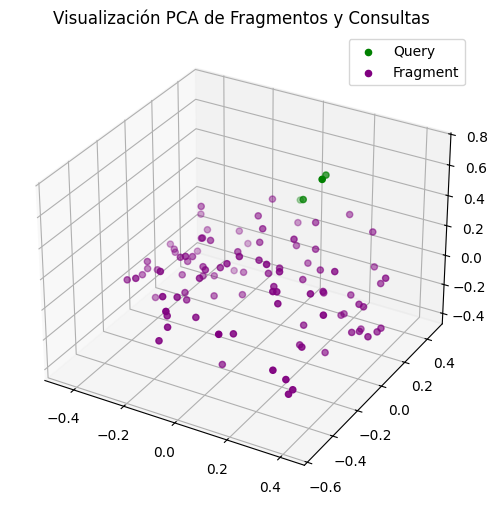

In [10]:
# visualización 
from mpl_toolkits.mplot3d import Axes3D

reduced = PCA(n_components=3).fit_transform(
    np.vstack((query_embeddings.cpu(), sentence_embeddings.cpu().numpy()[:100]))
)
labels = ["Query"]*len(queries) + ["Fragment"]*100
df_plot = pd.DataFrame(reduced, columns=["x", "y", "z"])
df_plot["label"] = labels

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
colors = {"Query": "green", "Fragment": "purple"}

for label in df_plot["label"].unique():
    subset = df_plot[df_plot["label"] == label]
    ax.scatter(subset["x"], subset["y"], subset["z"], label=label, c=colors[label])

ax.set_title("Visualización PCA de Fragmentos y Consultas")
ax.legend()
plt.show()

### Ejercicio 3

Apoyándose nuevamente en la sección de información. Recoge un texto extenso extraído,
divídelos en fragmentos, luego realiza extracciones de sustantivos (POS) y categoriza estos
sustantivos (NER), a continuación realiza una búsqueda de similitud filtrando por
sustantivos, compara las distintas técnicas de distancias vistas en clases, elija la mejor y
justifique la razón por la que esta técnica se ajusta para este tipo de búsquedas.


In [ ]:
import spacy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# cargar modelo de spacy
nlp = spacy.load("en_core_web_sm")

# cargamos el texto a analizar
with open("../datos/informacion/manual.txt", "r", encoding="utf-8") as f:
    texto = f.read()

# separamos las oraciones por spacy
doc = nlp(texto)
oraciones = [sent.text.strip() for sent in doc.sents if len(sent.text.strip()) > 20]

# extraer sustantivos y entidades por oración
sustantivos_por_oracion = []
entidades_por_oracion = []

for sent in oraciones:
    doc_sent = nlp(sent)
    sustantivos = [token.text for token in doc_sent if token.pos_ == "NOUN"]
    entidades = [(ent.text, ent.label_) for ent in doc_sent.ents]
    sustantivos_por_oracion.append(sustantivos)
    entidades_por_oracion.append(entidades)

# filtrar oraciones que tengan sustantivos
oraciones_filtradas = []
sustantivos_filtrados = []

for oracion, sustantivos in zip(oraciones, sustantivos_por_oracion):
    if sustantivos:
        oraciones_filtradas.append(oracion)
        sustantivos_filtrados.append(sustantivos)

print(f"{len(oraciones)}")

print("\n- Entidades")
for i in range(10):
    print(f"{i+1}: {entidades_por_oracion[i]}")



183

- Entidades
1: [('GAME', 'ORG'), ('PETER MCPHERSON', 'PERSON'), ('1-6', 'CARDINAL'), ('AGES 14', 'DATE'), ('4x4', 'CARDINAL'), ('Resource', 'ORG')]
2: []
3: [('-1', 'ORG')]
4: [('peter mcpherson\n§', 'PERSON')]
5: []
6: []
7: []
8: []
9: [('1', 'CARDINAL'), ('6', 'CARDINAL'), ('25', 'CARDINAL'), ('15', 'CARDINAL'), ('15', 'CARDINAL'), ('Resource', 'ORG'), ('1 scorepad\n•', 'QUANTITY'), ('126', 'CARDINAL'), ('1', 'CARDINAL'), ('6', 'CARDINAL'), ('90', 'CARDINAL'), ('1', 'CARDINAL')]
10: [('2', 'CARDINAL'), ('Resource', 'ORG'), ('the Town Hall', 'FAC'), ('Solo', 'PRODUCT')]


In [ ]:
# vectorizar con TF-IDF 
sustantivos_texto = [" ".join(s) for s in sustantivos_filtrados]
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(sustantivos_texto)

idx_consulta = 0
consulta_vector = tfidf_matrix[idx_consulta]
consulta_texto = sustantivos_texto[idx_consulta]


In [ ]:
# coseno
cos_sim = cosine_similarity(consulta_vector, tfidf_matrix)[0]
top_cos = np.argsort(-cos_sim)[1:4]

print("\n3 oraciones similares por COSENO:")
for i in top_cos:
    print(f"- {i}: {oraciones_filtradas[i]}", flush=True)

# jaccard
def jaccard_similarity(set_a, set_b):
    intersection = set_a.intersection(set_b)
    union = set_a.union(set_b)
    return len(intersection) / len(union) if union else 0

consulta_set = set(consulta_texto.split())
sim_jaccard = [
    jaccard_similarity(consulta_set, set(txt.split()))
    for txt in sustantivos_texto
]
top_jaccard = np.argsort(sim_jaccard)[-4:-1][::-1]

print("\n3 oraciones similares por JACCARD:")
for i in top_jaccard:
    print(f"- {i}: {oraciones_filtradas[i]}", flush=True)

#  Levnstein
dist_lev = [Levenshtein.distance(consulta_texto, txt) for txt in sustantivos_texto]
top_lev = np.argsort(dist_lev)[1:4]

print("\n3 oraciones similares por LEVENSHTEIN:")
for i in top_lev:
    print(f"- {i}: {oraciones_filtradas[i]}", flush=True)


3 oraciones similares por COSENO:
- 86: Additional Rules
•	Resource cubes and buildings are unlimited.
- 116: The game ends as normal, when your town is  completed (your town is filled with resources  and you cannot or choose not to construct any  buildings).
- 72: Players may construct Cottages before or after constructing 
  buildings, but unfed Cottages at game end score 0 
Completing Your Town
When your town is filled with resources and you cannot (or choose not to)  construct any buildings, your town is completed.

3 oraciones similares por JACCARD:
- 86: Additional Rules
•	Resource cubes and buildings are unlimited.
- 113: You choose to place  any 1 of the 3 resources shown in your town and  construct buildings as normal.
- 116: The game ends as normal, when your town is  completed (your town is filled with resources  and you cannot or choose not to construct any  buildings).

3 oraciones similares por LEVENSHTEIN:
- 116: The game ends as normal, when your town is  completed (yo

### Ejercicio 4
Mediante detección de idioma, separar los archivos en distintos lenguajes y guardar esa
información en un dataframe..


In [21]:
!pip install langdetect

     ---------------------------------------- 0.0/981.5 kB ? eta -:--:--
      ------------------------------------ 20.5/981.5 kB 640.0 kB/s eta 0:00:02
     -- ---------------------------------- 61.4/981.5 kB 656.4 kB/s eta 0:00:02
     --------- ---------------------------- 235.5/981.5 kB 1.8 MB/s eta 0:00:01
     -------------------------------------  972.8/981.5 kB 5.6 MB/s eta 0:00:01
     -------------------------------------- 981.5/981.5 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993364 sha256=4941380d7356766d4bc08b3708f30bbf1233dd0a096e5d8d7c15ad382f527122
  Stored in directory: c:\users\marya\


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\marya\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import os
import pandas as pd
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  

In [ ]:
carpeta = '../datos/informacion'  

In [24]:
datos = []

for archivo in os.listdir(carpeta):
    if archivo.endswith('.txt'):
        ruta_archivo = os.path.join(carpeta, archivo)
        with open(ruta_archivo, 'r', encoding='utf-8') as f:
            contenido = f.read()
            try:
                idioma = detect(contenido)
            except:
                idioma = 'desconocido'
            datos.append({'archivo': archivo, 'idioma': idioma})

In [25]:
df_idiomas = pd.DataFrame(datos)
print(df_idiomas)

              archivo idioma
0          manual.txt     en
1      review_bgg.txt     es
2  review_externa.txt     es
3          video1.txt     nl
4          video2.txt     en
5          video3.txt     en
6          video4.txt     es


### Ejercicio 5
En el caso de las reseñas realizadas por usuarios, utiliza análisis de sentimientos con
modelos pre entrenados y guarda la clasificación predecida de cada reseña.
Luego, crea un sistema de búsquedas por similitud semántica y que permita filtrar por
sentimiento para obtener.

In [ ]:
#!pip install transformers

from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import pandas as pd

# cargar modelo preentrenado
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# pipeline de análisis de sentimiento
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# cargar reseñas
with open("../datos/informacion/review_bgg.txt", "r", encoding="utf-8") as f:
    lineas = [linea.strip() for linea in f if len(linea.strip()) > 15]

# análisis de sentimiento
resultados = []
for linea in lineas:
    resultado = nlp(linea)[0]
    resultados.append({
        "texto": linea,
        "sentimiento_crudo": resultado["label"],
        "confianza": resultado["score"]
    })

# dataframe
df = pd.DataFrame(resultados)

# campo de sentimiento a 'positivo', 'neutral', 'negativo'
def clasificar(label):
    estrellas = int(label[0])
    if estrellas <= 2:
        return "negativo"
    elif estrellas == 3:
        return "neutral"
    else:
        return "positivo"

df["sentimiento"] = df["sentimiento_crudo"].apply(clasificar)
display(df.head())


Device set to use cpu


,texto,sentimiento_crudo,confianza,sentimiento
0,"¡Ah, los juegos de mesa! Solían ser los mismos de siempre, ¿verdad? Monopoly, Clue – divertidos por un tiempo, pero luego… meh. Luego llegó Carcassonne. Ese juego fue la droga de entrada, el que me mostró que los juegos de mesa podían ser más que solo tirar dados sin pensar. Pero no fue hasta que entré a Millennium Games (mi tienda local) que me di cuenta de lo PROFUNDO que era el agujero del conejo.",1 star,0.300246,negativo
1,"Imagina esto: ¡una tienda dedicada completamente a los juegos de mesa! Paredes llenas de cajas, desbordando posibilidades. Aventuras cooperativas para el trabajo en equipo, batallas épicas por la gloria, mundos fantásticos que suplicaban ser explorados. Era abrumador de la mejor manera posible. Aquí estaba yo, un novato en juegos de mesa, rodeado de un universo que nunca supe que existía.",5 stars,0.665199,positivo
2,"Sintiendo un poco de confusión, un amable empleado de la tienda vino al rescate. Olvídate de los discursos de ventas, esta persona realmente quería ayudarnos a encontrar un juego que amaríamos. Ahí es donde entra Tiny Towns. La portada de la caja puede que no haya gritado ""clásico instantáneo"", pero la pasión de este empleado era contagiosa. ¡Incluso ofrecieron una garantía de devolución de dinero! (Alerta de spoiler: nunca la necesité).",1 star,0.622779,negativo
3,"Avancemos hasta hoy, y Tiny Towns sigue siendo un elemento básico en la familia. ¡Más de 100 juegos en más de 4 años, y nunca se hace viejo! Es la mezcla perfecta de estrategia y rompecabezas, una elección fantástica tanto para nuevos jugadores como para jugadores experimentados. Además, ¡el arte del juego es ridículamente lindo!",5 stars,0.906190,positivo
4,"Tiny Towns es un juego para 1-6 jugadores diseñado por y publicado por Alderac Entertainment Group (AEG). Nunca lo he jugado en solitario, pero lo he disfrutado como juego de cita y hasta con seis jugadores. Siento que este juego funciona bien en cualquier cantidad de jugadores.",4 stars,0.493742,positivo


In [2]:
# !pip install sentence-transformers

from sentence_transformers import SentenceTransformer, util

# Cargar modelo de embeddings
modelo = SentenceTransformer('msmarco-MiniLM-L-6-v3')

# Generar embeddings para todas las reseñas
df["embedding"] = df["texto"].apply(lambda x: modelo.encode(x))


C:\Users\marya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\marya\.cache\huggingface\hub\models--sentence-transformers--msmarco-MiniLM-L-6-v3. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet 

In [ ]:
# consulta y filtro
consulta = "me parece un juego muy aburrido"
sentimiento_deseado = "negativo"

#filtrar por sentimiento
df_filtrado = df[df["sentimiento"] == sentimiento_deseado].reset_index(drop=True)

# embeddings del corpus filtrado
corpus_embeddings = list(df_filtrado["embedding"])

# embedding de la consulta
embedding_consulta = modelo.encode(consulta)

embedding_consulta = modelo.encode(consulta, convert_to_tensor=True)
corpus_embeddings = modelo.encode(df_filtrado["texto"].tolist(), convert_to_tensor=True)

# calcular similitud
resultados = util.semantic_search(embedding_consulta, corpus_embeddings, top_k=3)[0]

# resultados
for i, r in enumerate(resultados):
    idx = r["corpus_id"]
    print(f"Resultado {i+1}:")
    print(f"Similitud: {r['score']:.4f}")
    print(f"Texto: {df_filtrado.iloc[idx]['texto']}")
    print()


Resultado 1:
Similitud: 0.4177
Texto: ¡Ah, los juegos de mesa! Solían ser los mismos de siempre, ¿verdad? Monopoly, Clue – divertidos por un tiempo, pero luego… meh. Luego llegó Carcassonne. Ese juego fue la droga de entrada, el que me mostró que los juegos de mesa podían ser más que solo tirar dados sin pensar. Pero no fue hasta que entré a Millennium Games (mi tienda local) que me di cuenta de lo PROFUNDO que era el agujero del conejo.

Resultado 2:
Similitud: 0.3530
Texto: **Puntuación y ganar**: El juego termina cuando no se pueden construir más edificios o tomar más recursos. Los jugadores puntúan puntos por edificios completados basados en las cartas de edificios. Resta un punto por cada espacio no utilizado en tus tableros. ¡El jugador con más puntos gana el juego!

Resultado 3:
Similitud: 0.3209
Texto: Sintiendo un poco de confusión, un amable empleado de la tienda vino al rescate. Olvídate de los discursos de ventas, esta persona realmente quería ayudarnos a encontrar un juego

### Ejercicio 6
Crea un set de datos de consultas (más de 300 preguntas en total) y categorizalas entre la
fuente de datos que pueda llegar a responder esa pregunta entre estadísticas,
información y relaciones.

Por ejemplo:
- ¿Cómo gano en el ajedrez? -> Información
- ¿Quién trabajó para el ta-te-ti? -> Relaciones
- ¿Qué puntaje tienen las damas? -> Estadística

A continuación, transforma esas consultas en vectores y entrena un modelo de clasificación
(a gusto del estudiante) en donde pueda predecir la categoría a través de la consulta
ingresada.
Agregar métricas y análisis durante todo el desarrollo, trabaje en varios modelos y
comparelos.

In [ ]:
# LIBRERÍAS
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# cargamos preguntas
df = pd.read_csv("preguntas_clasificadas.csv")  

# variables
X = df["pregunta"]
y = df["categoria"]

# división del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# vectorización
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# modelo multinomial Naive Bayes
modelo_nb = MultinomialNB()
modelo_nb.fit(X_train_tfidf, y_train)
y_pred_nb = modelo_nb.predict(X_test_tfidf)

# modelo logistic regression
modelo_log = LogisticRegression(max_iter=1000)
modelo_log.fit(X_train_tfidf, y_train)
y_pred_log = modelo_log.predict(X_test_tfidf)

# evaluación y comparación de modelos
print("Multinomial Naive Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

print("Regresión Logística")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))



--- Modelo 1: Multinomial Naive Bayes ---
Accuracy: 0.9864864864864865
Matriz de Confusión:
[[25  0  0]
 [ 1 23  0]
 [ 0  0 25]]
Reporte:
              precision    recall  f1-score   support

estadisticas       0.96      1.00      0.98        25
 informacion       1.00      0.96      0.98        24
  relaciones       1.00      1.00      1.00        25

    accuracy                           0.99        74
   macro avg       0.99      0.99      0.99        74
weighted avg       0.99      0.99      0.99        74


--- Modelo 2: Regresión Logística ---
Accuracy: 1.0
Matriz de Confusión:
[[25  0  0]
 [ 0 24  0]
 [ 0  0 25]]
Reporte:
              precision    recall  f1-score   support

estadisticas       1.00      1.00      1.00        25
 informacion       1.00      1.00      1.00        24
  relaciones       1.00      1.00      1.00        25

    accuracy                           1.00        74
   macro avg       1.00      1.00      1.00        74
weighted avg       1.00      1.00 